# Technical indicator classes
In order to use lots of indicators in one strategy, we have to make a class that handles calculations for each technical indicator. That will make the code simpler.

In [33]:
import numpy as np
import pandas as pd
import pandas_ta as ta #indicators
import plotly.graph_objects as go
#import matplotlib.pyplot as plt
#plt.style.use("seaborn")
#import sys

pandas-ta provides more than to 200 indicators, so we dont have to do the calculations:

https://github.com/twopirllc/pandas-ta

In [81]:
#help with ta
#df = pd.DataFrame()

# Help about this, 'ta', extension
help(df.ta)

# List of all indicators
#df.ta.indicators()

# Help about an indicator such as bbands
#help(ta.sma)

Help on AnalysisIndicators in module pandas_ta.core object:

class AnalysisIndicators(BasePandasObject)
 |  AnalysisIndicators(pandas_obj)
 |  
 |  This Pandas Extension is named 'ta' for Technical Analysis. In other words,
 |  it is a Numerical Time Series Feature Generator where the Time Series data
 |  is biased towards Financial Market data; typical data includes columns
 |  named :"open", "high", "low", "close", "volume".
 |  
 |  This TA Library hopefully allows you to apply familiar and unique Technical
 |  Analysis Indicators easily with the DataFrame Extension named 'ta'. Even
 |  though 'ta' is a Pandas DataFrame Extension, you can still call Technical
 |  Analysis indicators individually if you are more comfortable with that
 |  approach or it allows you to easily and automatically apply the indicators
 |  with the strategy method. See: help(ta.strategy).
 |  
 |  By default, the 'ta' extension uses lower case column names: open, high,
 |  low, close, and volume. You can ove

In [2]:
#load raw data 
raw = None
def load_data():
    global raw
    start = "2022-01-31"
    end = "2023-06-30"
    raw = pd.read_csv("data/5m.csv", parse_dates = ["Date"], index_col = "Date").dropna()
    raw = raw.loc[start:end]
    raw = raw[["Close"]].rename(columns={"Close": "price"}) #just use these columns
    raw["returns"] = np.log(raw.price / raw.price.shift(1))
    raw    

## Overlap Indicators

In [118]:
#Simple Moving Average
load_data() #resets data
class SMA():
    
    def __init__(self, data, SMA_S, SMA_L, column, default_strategy = 1, weight = 1):
        self.data = data # Dataframe
        self.weight = weight #weight on the strategy (importance)
        self.SMA_S = column + "|SMA|" + str(SMA_S) # short SMA
        self.SMA_L = column + "|SMA|" + str(SMA_L) # long SMA
        self.short = SMA_S
        self.long = SMA_L
        self.column = column # column to use SMA
        self.default_strategy = default_strategy #strategy to use
        
    def calculate(self, force = False): #calculate for all dataframe
        if not self.SMA_S in self.data.columns or force:
            self.data[self.SMA_S] = self.data[self.column].rolling(self.short).mean()  
        if not self.SMA_L in self.data.columns or force:    
            self.data[self.SMA_L] = self.data[self.column].rolling(self.long).mean()
        #DONT DROP NA BECAUSE OTHER INDICATORS NEED THAT ROWS!!!
    
    def calculate_for_last_row(self): #calculate just for last row
        self.data.loc[self.data.index[-1],self.SMA_S] = self.data[self.column].iloc[-self.short:].rolling(self.short).mean()[-1]
        self.data.loc[self.data.index[-1],self.SMA_L] = self.data[self.column].iloc[-self.long:].rolling(self.long).mean()[-1]
    
    def strategy(self, row, num = -1):
        return self.strategy1(row)
    
    def strategy1(self, row):
        '''Returns predicted position (1,0 or -1)'''
        if self.data[self.SMA_S][row] > self.data[self.SMA_L][row]: # signal to go long
            return 1
        elif self.data[self.SMA_S][row] < self.data[self.SMA_L][row]: # signal to go short
            return -1
        else:
            return 0
sma = SMA(
        data = raw,
        SMA_S = 50,
        SMA_L = 200,
        column = "price"
         )
sma.calculate() #calculate for all dataframe
sma.calculate_for_last_row() #calculate just for last row
print(sma.strategy(-1, num = 1)) #print strategy for last row
raw #notice that original dataframe is changed

1


,price,returns,price|SMA|50,price|SMA|200
Date,,,,
2022-07-12 11:15:00,19729.8,NaN,NaN,NaN
2022-07-12 11:20:00,19713.8,-0.000811,NaN,NaN
2022-07-12 11:25:00,19772.7,0.002983,NaN,NaN
2022-07-12 11:30:00,19823.3,0.002556,NaN,NaN
2022-07-12 11:35:00,19766.9,-0.002849,NaN,NaN
...,...,...,...,...
2022-08-16 04:10:00,24550.0,0.002039,24324.026,24250.9185
2022-08-16 04:15:00,24450.0,-0.004082,24327.712,24250.4185
2022-08-16 04:20:00,24508.3,0.002382,24335.530,24251.9000


In [107]:
#Exponentially Weighted Moving Average
load_data() #resets data
class EWMA():
    #https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html
    #approx average periods n are calculated by: n is approx 1/(1 - alpha)
    # => we are going to calculate alpha given n approx average periods as: alpha = 1- 1/n
    #Important: approx_avg_period are float in (1, inf). In (1,2) considers high weights for current day
    def __init__(self, data, approx_avg_period_s, approx_avg_period_l,
                 column, default_strategy = 1, weight = 1):
        self.data = data # Dataframe
        self.weight = weight #weight on the strategy (importance)
        self.approx_avg_period_s = approx_avg_period_s
        self.approx_avg_period_l = approx_avg_period_l
        self.alpha_s = 1-1/approx_avg_period_s #alpha for short EWMA
        self.alpha_l = 1-1/approx_avg_period_l #alpha for long EWMA
        self.column = column # column to use SMA
        self.EWMA_S = column + "|EWMA|a" + str(approx_avg_period_s) # short SMA using alpha
        self.EWMA_L = column + "|EWMA|a" + str(approx_avg_period_l) # long SMA using alpha
        self.default_strategy = default_strategy #strategy to use
        
    def calculate(self, force = False): #calculate for all dataframe
        if not self.EWMA_S in self.data.columns or force:
            self.data[self.EWMA_S] = self.data[self.column].ewm(alpha = self.alpha_s).mean()
        if not self.EWMA_L in self.data.columns or force:
            self.data[self.EWMA_L] = self.data[self.column].ewm(alpha = self.alpha_l).mean()
        #DONT DROP NA BECAUSE OTHER INDICATORS NEED THAT ROWS!!!
    def calculate_for_last_row(self): #calculate just for last row
        s = round(self.approx_avg_period_s)
        l = round(self.approx_avg_period_l)
        # precision. EWMA with more info gives more approx results as "calculate". recommend p = 2
        # for small s, needs more precision.
        p_s = max([100, s*2]) # min 100 of precision
        p_l = max([100, l*2]) # min 100 of precision
        #calculate EWMA and just update last row
        self.data.loc[self.data.index[-1],self.EWMA_S] = self.data[self.column][-p_s:].ewm(alpha = self.alpha_s).mean()[-1]
        self.data.loc[self.data.index[-1],self.EWMA_L] = self.data[self.column][-p_l:].ewm(alpha = self.alpha_l).mean()[-1]
    
    def strategy(self, row, num = -1):
        return self.strategy1(row)    
    
    def strategy1(self, row):
        '''Returns predicted position (1,0 or -1)'''
        if self.data[self.EWMA_S][row] > self.data[self.EWMA_L][row]: # signal to go long
            return 1
        elif self.data[self.EWMA_S][row] < self.data[self.EWMA_L][row]: # signal to go short
            return -1
        else:
            return 0
        
ewma = EWMA(
        data = raw,
        approx_avg_period_s = 1.43546789,
        approx_avg_period_l = 99,
        column = "price"
         )
ewma.calculate() #calculate for all dataframe
ewma.calculate_for_last_row() #calculate just for last row
print(ewma.strategy(-1, num = 1)) #print strategy for last row
raw #notice that original dataframe is changed

1


,price,returns,price|EWMA|a1.43546789,price|EWMA|a99
Date,,,,
2022-07-12 11:15:00,19729.8,NaN,19729.800000,19729.800000
2022-07-12 11:20:00,19713.8,-0.000811,19720.369580,19713.960000
2022-07-12 11:25:00,19772.7,0.002983,19744.353016,19772.106727
2022-07-12 11:30:00,19823.3,0.002556,19775.680935,19822.782897
2022-07-12 11:35:00,19766.9,-0.002849,19772.494286,19767.464474
...,...,...,...,...
2022-08-16 04:10:00,24550.0,0.002039,24500.496954,24549.491742
2022-08-16 04:15:00,24450.0,-0.004082,24485.178045,24451.004967
2022-08-16 04:20:00,24508.3,0.002382,24492.192391,24507.721262


## Volatility Indicators

In [110]:
#Exponentially Weighted Moving Average
load_data() #resets data
class BollingerBands():
    
    def __init__(self, data, column = "price", dev = 1, periods = 50,
                 default_strategy = 1, weight = 1):
        self.data = data # Dataframe
        self.weight = weight #weight on the strategy (importance)
        self.column = column #column used to calculate BBs
        self.dev = dev #standard deviations for BBs
        self.BBS = column + "|BBs|" + str(dev)+"|"+str(periods) #Name of BBS
        self.SMA = column + "|SMA|" + str(periods) #SMA FOR BBs
        self.last_position = 0 #saves last position
        self.periods = periods
        self.default_strategy = default_strategy #strategy to use
        
    def calculate(self, force = False): #calculate for all dataframe
        if not self.BBS+"|Distance" in self.data.columns or force:
            SM = self.data[self.column].rolling(self.periods) #SMA one step before calculating mean()
            if not self.SMA in self.data.columns or force: self.data[self.SMA] = SM.mean()
            self.data[self.BBS+"|Lower"] = self.data[self.SMA] - SM.std() * self.dev
            self.data[self.BBS+"|Upper"] = self.data[self.SMA] + SM.std() * self.dev
            self.data[self.BBS+"|Distance"] = self.data[self.column] - self.data[self.SMA] 
        #DONT DROP NA BECAUSE OTHER INDICATORS NEED THAT ROWS!!!
    def calculate_for_last_row(self): #calculate just for last row
        SM = self.data[self.column][-self.periods:].rolling(self.periods)
        self.data.loc[self.data.index[-1],self.SMA] = SM.mean()[-1]
        self.data.loc[self.data.index[-1],self.BBS + "|Lower"] = self.data[self.SMA][-1] - SM.std()[-1] * self.dev
        self.data.loc[self.data.index[-1],self.BBS + "|Upper"] = self.data[self.SMA][-1] + SM.std()[-1] * self.dev
        self.data.loc[self.data.index[-1],self.BBS + "|Distance"] = self.data[self.column][-1] - self.data[self.SMA][-1] 

    def strategy(self, row, num = -1):
        return self.strategy1(row)  
        
    def strategy1(self, row):
        '''Returns predicted position (1,0 or -1)'''
        ### How to evaluate vectorized strategy ###
        #self.data["position"] = np.where(self.data[self.column] < self.data.Lower, 1, np.nan)
        #self.data["position"] = np.where(self.data[self.column] > self.data.Upper, -1, self.data["position"])
        #self.data["position"] = np.where(self.data.distance * self.data.distance.shift(1) < 0, 0, self.data["position"])
        #self.data["position"] = self.data.position.ffill().fillna(0) 
                
        if self.data[self.column][row] < self.data[self.BBS+"|Lower"][row]:
            self.last_position = 1
        elif self.data[self.column][row] > self.data[self.BBS+"|Upper"][row]:
            self.last_position = -1 
        elif row != 0 and self.data[self.BBS+"|Distance"][row] * self.data[self.BBS+"|Distance"][row-1] < 0:
            self.last_position = 0
        return self.last_position
        
        
bbs = BollingerBands(
        data = raw,
        dev = 1, 
        periods = 50,
        column = "price"
         )
bbs.calculate() #calculate for all dataframe
bbs.calculate_for_last_row() #calculate just for last row
print(bbs.strategy(-1, num = 1)) #print strategy for last row
raw #notice that original dataframe is changed

0


,price,returns,price|SMA|50,price|BBs|1|50|Lower,price|BBs|1|50|Upper,price|BBs|1|50|Distance
Date,,,,,,
2022-07-12 11:15:00,19729.8,NaN,NaN,NaN,NaN,NaN
2022-07-12 11:20:00,19713.8,-0.000811,NaN,NaN,NaN,NaN
2022-07-12 11:25:00,19772.7,0.002983,NaN,NaN,NaN,NaN
2022-07-12 11:30:00,19823.3,0.002556,NaN,NaN,NaN,NaN
2022-07-12 11:35:00,19766.9,-0.002849,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2022-08-16 04:10:00,24550.0,0.002039,24324.026,24141.569419,24506.482581,225.974
2022-08-16 04:15:00,24450.0,-0.004082,24327.712,24144.597338,24510.826662,122.288
2022-08-16 04:20:00,24508.3,0.002382,24335.530,24153.234947,24517.825053,172.770


<AxesSubplot:xlabel='Date'>

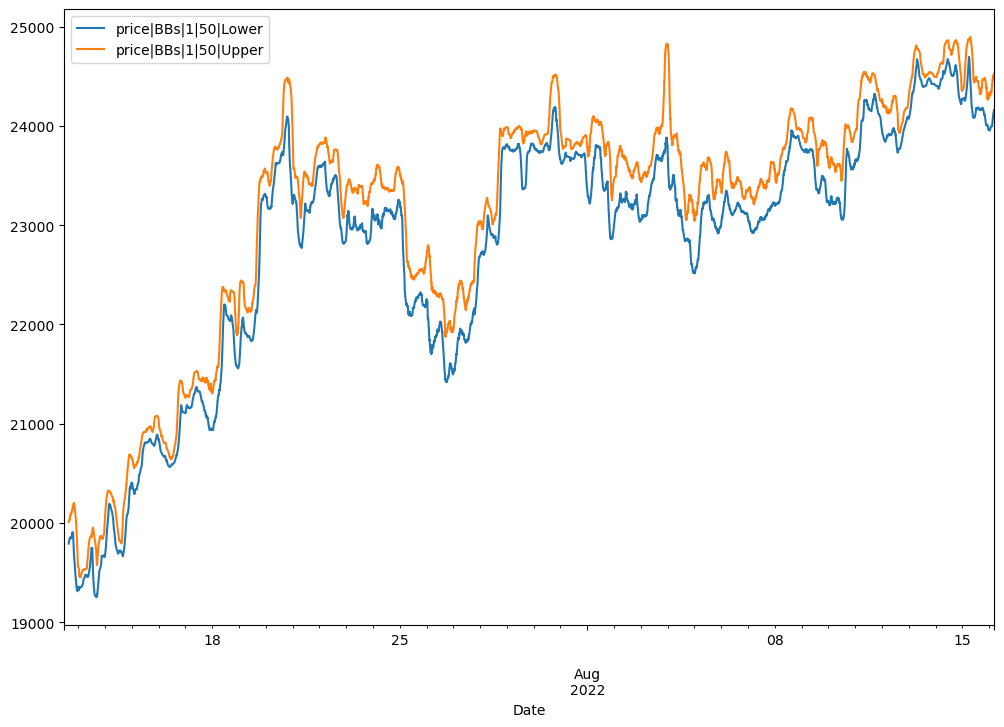

In [109]:
raw[["price|BBs|1|50|Lower", "price|BBs|1|50|Upper"]].plot(figsize = (12, 8))

## Momentum Indicators

In [111]:
#Moving Average Convergence Divergence 
load_data() #resets data
class MACD():
    #https://www.alpharithms.com/calculate-macd-python-272222/
    def __init__(self, data, column, fast=12, slow=26, signal=9, 
                 default_strategy = 1, weight = 1):
        self.data = data # Dataframe
        self.weight = weight #weight on the strategy (importance)
        self.column = column # column to use SMA
        self.fast = fast
        self.slow = slow
        self.signal = signal
        #column names given by pandas_ta
        self.macd = column + "_MACD_" + str(fast) + "_"+ str(slow)  + "_" + str(signal) #ewmaFast - ewmaSlow
        self.macds = column + "_MACDs_" + str(fast) + "_"+ str(slow)  + "_" + str(signal) #ewmaSignal
        self.macdh = column + "_MACDh_" + str(fast) + "_"+ str(slow)  + "_" + str(signal) #macd - macds
        self.default_strategy = default_strategy #strategy to use
        
    def calculate(self, force = False): #calculate for all dataframe
        if not self.macd in self.data.columns or force:
            self.data.ta.macd(close=self.column, fast=self.fast, slow=self.slow, 
                              signal=self.signal, append=True, prefix = self.column)  
        #DONT DROP NA BECAUSE OTHER INDICATORS NEED THAT ROWS!!!
    def calculate_for_last_row(self): #calculate just for last row
        #approximate results, dont use all dataframe 
        cols = self.data[-250:].ta.macd(close=self.column, fast=self.fast, slow=self.slow, 
                          signal=self.signal, append=False, prefix = self.column)
        #append results to last row
        self.data.loc[self.data.index[-1], self.macd] = cols[self.macd][-1]
        self.data.loc[self.data.index[-1], self.macdh] = cols[self.macdh][-1]
        self.data.loc[self.data.index[-1], self.macds] = cols[self.macds][-1]
   
    def strategy(self, row, num = -1):
        return self.strategy1(row)          
        
    def strategy1(self, row):
        '''Returns predicted position (1,0 or -1)'''
        if self.data[self.macdh][row] > 0: # signal to go long
            return 1
        else:
            return -1

macd = MACD(
        data = raw,
        column = "price"
         )
macd.calculate() #calculate for all dataframe
macd.calculate_for_last_row() #calculate just for last row
print(macd.strategy(-1, num = 1)) #print strategy for last row
raw #notice that original dataframe is changed

-1


,price,returns,price_MACD_12_26_9,price_MACDh_12_26_9,price_MACDs_12_26_9
Date,,,,,
2022-07-12 11:15:00,19729.8,NaN,NaN,NaN,NaN
2022-07-12 11:20:00,19713.8,-0.000811,NaN,NaN,NaN
2022-07-12 11:25:00,19772.7,0.002983,NaN,NaN,NaN
2022-07-12 11:30:00,19823.3,0.002556,NaN,NaN,NaN
2022-07-12 11:35:00,19766.9,-0.002849,NaN,NaN,NaN
...,...,...,...,...,...
2022-08-16 04:10:00,24550.0,0.002039,48.505494,-1.208913,49.714407
2022-08-16 04:15:00,24450.0,-0.004082,42.697180,-5.613782,48.310962
2022-08-16 04:20:00,24508.3,0.002382,42.310641,-4.800257,47.110897


In [2]:
df = pd.DataFrame()
# Help about an indicator
help(ta.rsi)

Help on function rsi in module pandas_ta.momentum.rsi:

rsi(close, length=None, scalar=None, talib=None, drift=None, offset=None, **kwargs)
    Relative Strength Index (RSI)
    
    The Relative Strength Index is popular momentum oscillator used to measure the
    velocity as well as the magnitude of directional price movements.
    
    Sources:
        https://www.tradingview.com/wiki/Relative_Strength_Index_(RSI)
    
    Calculation:
        Default Inputs:
            length=14, scalar=100, drift=1
        ABS = Absolute Value
        RMA = Rolling Moving Average
    
        diff = close.diff(drift)
        positive = diff if diff > 0 else 0
        negative = diff if diff < 0 else 0
    
        pos_avg = RMA(positive, length)
        neg_avg = ABS(RMA(negative, length))
    
        RSI = scalar * pos_avg / (pos_avg + neg_avg)
    
    Args:
        close (pd.Series): Series of 'close's
        length (int): It's period. Default: 14
        scalar (float): How much to magnify.

In [59]:
load_data() #resets data
raw.ta.rsi(close="price", length = 14, append = True)
raw

,price,returns,RSI_14
Date,,,
2022-07-12 11:15:00,19729.8,NaN,NaN
2022-07-12 11:20:00,19713.8,-0.000811,NaN
2022-07-12 11:25:00,19772.7,0.002983,NaN
2022-07-12 11:30:00,19823.3,0.002556,NaN
2022-07-12 11:35:00,19766.9,-0.002849,NaN
...,...,...,...
2022-08-16 04:10:00,24550.0,0.002039,54.328932
2022-08-16 04:15:00,24450.0,-0.004082,50.787570
2022-08-16 04:20:00,24508.3,0.002382,52.722421


In [112]:
#Relative Strength Index
load_data() #resets data
class RSI():
    #https://www.tradingview.com/support/solutions/43000502338-relative-strength-index-rsi/
    def __init__(self, data, column, length=14, default_strategy = 1, weight = 1):
        self.data = data # Dataframe
        self.weight = weight #weight on the strategy (importance)
        self.column = column # column to use SMA
        self.length = length
        #column names given by pandas_ta
        self.rsi = column + "_RSI_" + str(length)
        self.default_strategy = default_strategy #strategy to use
        
    def calculate(self, force = False): #calculate for all dataframe
        if not self.rsi in self.data.columns or force:
            self.data.ta.rsi(close=self.column, length = self.length, append=True, prefix = self.column)  
        #DONT DROP NA BECAUSE OTHER INDICATORS NEED THAT ROWS!!!
    def calculate_for_last_row(self): #calculate just for last row
        #approximate results, dont use all dataframe 
        cols = self.data[-200:].ta.rsi(close=self.column, length = self.length, append=False)
        #append results to last row
        self.data.loc[self.data.index[-1], self.rsi] = cols[-1]

    def strategy(self, row, num = -1):
        if num == -1: num = self.default_strategy #use default strategy 
        if num == 2:
            return self.strategy2(row)
        return self.strategy1(row)   
        
    def strategy1(self, row):
        '''Returns predicted position (1,0 or -1)'''
        if self.data[self.rsi][row] > 70: 
            return -1
        elif self.data[self.rsi][row] < 30:
            return 1
        return 0
    
    def strategy2(self, row):
        '''Returns predicted position (1,0 or -1)'''
        if self.data[self.rsi][row] > 70: 
            return 1
        elif self.data[self.rsi][row] < 30:
            return -1
        return 0

rsi = RSI(
        data = raw,
        length = 14,
        column = "price"
         )
rsi.calculate() #calculate for all dataframe
rsi.calculate_for_last_row() #calculate just for last row
print(rsi.strategy(-1, num = 1)) #print strategy for last row
raw #notice that original dataframe is changed

0


,price,returns,price_RSI_14
Date,,,
2022-07-12 11:15:00,19729.8,NaN,NaN
2022-07-12 11:20:00,19713.8,-0.000811,NaN
2022-07-12 11:25:00,19772.7,0.002983,NaN
2022-07-12 11:30:00,19823.3,0.002556,NaN
2022-07-12 11:35:00,19766.9,-0.002849,NaN
...,...,...,...
2022-08-16 04:10:00,24550.0,0.002039,54.328932
2022-08-16 04:15:00,24450.0,-0.004082,50.787570
2022-08-16 04:20:00,24508.3,0.002382,52.722421


## Candles Indicators

In [69]:
help(ta.cdl_pattern)

Help on function cdl_pattern in module pandas_ta.candles.cdl_pattern:

cdl_pattern(open_, high, low, close, name: Union[str, Sequence[str]] = 'all', scalar=None, offset=None, **kwargs) -> pandas.core.frame.DataFrame
    Candle Pattern
    
    A wrapper around all candle patterns.
    
    Examples:
    
    Get all candle patterns (This is the default behaviour)
    >>> df = df.ta.cdl_pattern(name="all")
    Or
    >>> df.ta.cdl("all", append=True) # = df.ta.cdl_pattern("all", append=True)
    
    Get only one pattern
    >>> df = df.ta.cdl_pattern(name="doji")
    Or
    >>> df.ta.cdl("doji", append=True)
    
    Get some patterns
    >>> df = df.ta.cdl_pattern(name=["doji", "inside"])
    Or
    >>> df.ta.cdl(["doji", "inside"], append=True)
    
    Args:
        open_ (pd.Series): Series of 'open's
        high (pd.Series): Series of 'high's
        low (pd.Series): Series of 'low's
        close (pd.Series): Series of 'close's
        name: (Union[str, Sequence[str]]): name of 

In [59]:
#load raw data 
raw = None
def load_data():
    global raw
    start = "2022-01-31"
    end = "2023-06-30"
    raw = pd.read_csv("data/btc-usdt_dic_1m.csv", parse_dates = ["Date"], index_col = "Date").dropna()
    raw = raw.loc[start:end]
    raw["returns"] = np.log(raw.Close / raw.Close.shift(1))
    raw  
load_data()
raw

,Open,High,Low,Close,Volume,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,returns
Date,,,,,,,,,,
2022-12-01 09:02:00,17111.3,17112.1,17106.6,17106.8,77.072,1.318602e+06,13,54.776,9.371811e+05,NaN
2022-12-01 09:03:00,17107.3,17110.8,17106.8,17106.8,111.637,1.909974e+06,10,51.011,8.727849e+05,0.000000
2022-12-01 09:04:00,17106.8,17110.8,17106.8,17110.8,32.783,5.609147e+05,16,20.761,3.552367e+05,0.000234
2022-12-01 09:05:00,17108.3,17108.3,17104.1,17107.1,65.628,1.122645e+06,14,17.254,2.951780e+05,-0.000216
2022-12-01 09:06:00,17106.4,17108.3,17104.9,17104.9,184.039,3.148192e+06,23,130.154,2.226456e+06,-0.000129
...,...,...,...,...,...,...,...,...,...,...
2022-12-08 07:37:00,16925.0,16930.0,16850.0,16930.0,25.131,4.253905e+05,12,24.196,4.096357e+05,0.000295
2022-12-08 07:38:00,16896.1,16938.0,16847.0,16847.0,166.824,2.818056e+06,30,77.963,1.319293e+06,-0.004915
2022-12-08 07:39:00,16936.0,16938.0,16847.0,16847.1,156.605,2.646544e+06,27,89.643,1.518373e+06,0.000006


In [86]:
df = pd.DataFrame()
#df.ta.indicators()
# Help about an indicator
#help(ta.cdl_pattern)
df = ta.cdl_pattern(name = "hammer", open_ = raw["Open"], high = raw["High"], 
               close = raw["Close"], low = raw["Low"])
df[df["CDL_HAMMER"]== 100]

,CDL_HAMMER
Date,
2022-12-01 10:18:00,100.0
2022-12-01 10:21:00,100.0
2022-12-01 10:26:00,100.0
2022-12-01 10:40:00,100.0
2022-12-01 10:54:00,100.0
...,...
2022-12-08 05:26:00,100.0
2022-12-08 05:27:00,100.0
2022-12-08 05:40:00,100.0


In [87]:
df = pd.DataFrame()
#df.ta.indicators()
# Help about an indicator
#help(ta.cdl_pattern)
df = ta.cdl_pattern(name = "invertedhammer", open_ = raw["Open"], high = raw["High"], 
               close = raw["Close"], low = raw["Low"])
df[df["CDL_INVERTEDHAMMER"]== 100]



,CDL_INVERTEDHAMMER
Date,
2022-12-01 09:18:00,100.0
2022-12-01 09:51:00,100.0
2022-12-01 10:05:00,100.0
2022-12-01 10:06:00,100.0
2022-12-01 10:39:00,100.0
...,...
2022-12-08 05:13:00,100.0
2022-12-08 05:39:00,100.0
2022-12-08 05:50:00,100.0


In [76]:
df = pd.read_csv('data/btc-usdt_dic_1m.csv').head(200)

fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])

fig.show()

In [146]:
#Hammer (tail looking down)
#InverteHammer (tail looking up)
load_data() #resets data
class Hammer():
    #https://www.tradingview.com/support/solutions/43000502338-relative-strength-index-rsi/
    def __init__(self, data, open_ = "Open", high = "High", low = "Low",
                 close = "Close", default_strategy = 1, weight = 1):
        self.data = data # Dataframe
        self.weight = weight #weight on the strategy (importance)
        self.open_ = open_
        self.high = high
        self.low = low
        self.close = close
        self.default_strategy = default_strategy #strategy to use
        #column names given by pandas_ta
        self.hammer = "CDL_HAMMER" 
        self.invhammer = "CDL_INVERTEDHAMMER"
        
    def calculate(self, force = False): #calculate for all dataframe
        if not self.hammer in self.data.columns or force:
            res = ta.cdl_pattern(name = "hammer", open_ = self.data[self.open_], high = self.data[self.high], 
               close = self.data[self.close], low = self.data[self.low])
            self.data[self.hammer] = np.sign(res)
        if not self.invhammer in self.data.columns or force:
            res = ta.cdl_pattern(name = "invertedhammer", open_ = self.data[self.open_], 
                high = self.data[self.high], close = self.data[self.close], low = self.data[self.low]) 
            self.data[self.invhammer] = np.sign(res)
        #DONT DROP NA BECAUSE OTHER INDICATORS NEED THAT ROWS!!!
    def calculate_for_last_row(self): #calculate just for last row
        res = ta.cdl_pattern(name = "hammer", open_ = self.data[self.open_][-1:], 
                             high = self.data[self.high][-1:], close = self.data[self.close][-1:], 
                             low = self.data[self.low][-1:])
        resinv = ta.cdl_pattern(name = "invertedhammer", open_ = self.data[self.open_][-1:], 
                             high = self.data[self.high][-1:], close = self.data[self.close][-1:], 
                             low = self.data[self.low][-1:])
        #append results to last row
        self.data.loc[self.data.index[-1], self.hammer] = np.sign(res[self.hammer][0])
        self.data.loc[self.data.index[-1], self.invhammer] = np.sign(resinv[self.invhammer][0])

    def strategy(self, row, num = -1):
        if num == -1: num = self.default_strategy #use default strategy 
        if num == 2:
            return self.strategy2(row)
        return self.strategy1(row)   
        
    def strategy1(self, row):
        '''Returns predicted position (1,0 or -1)'''
        if self.data[self.hammer][row] == 1: 
            return 1
        elif self.data[self.invhammer][row] == 1:
            return -1
        return 0
    
    def strategy2(self, row):
        '''Returns predicted position (1,0 or -1)'''
        if self.data[self.hammer][row] == 1: 
            return -1
        elif self.data[self.invhammer][row] == 1:
            return 1
        return 0

hammer = Hammer(
        data = raw,
        default_strategy = 1,
        weight = 1
         )
hammer.calculate() #calculate for all dataframe
hammer.calculate_for_last_row() #calculate just for last row
#print(hammer.strategy(-1, num = 1)) #print strategy for last row
raw #notice that original dataframe is changed

,Open,High,Low,Close,Volume,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,returns,CDL_HAMMER,CDL_INVERTEDHAMMER
Date,,,,,,,,,,,,
2022-12-01 09:02:00,17111.3,17112.1,17106.6,17106.8,77.072,1.318602e+06,13,54.776,9.371811e+05,NaN,0.0,0.0
2022-12-01 09:03:00,17107.3,17110.8,17106.8,17106.8,111.637,1.909974e+06,10,51.011,8.727849e+05,0.000000,0.0,0.0
2022-12-01 09:04:00,17106.8,17110.8,17106.8,17110.8,32.783,5.609147e+05,16,20.761,3.552367e+05,0.000234,0.0,0.0
2022-12-01 09:05:00,17108.3,17108.3,17104.1,17107.1,65.628,1.122645e+06,14,17.254,2.951780e+05,-0.000216,0.0,0.0
2022-12-01 09:06:00,17106.4,17108.3,17104.9,17104.9,184.039,3.148192e+06,23,130.154,2.226456e+06,-0.000129,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-08 07:37:00,16925.0,16930.0,16850.0,16930.0,25.131,4.253905e+05,12,24.196,4.096357e+05,0.000295,0.0,0.0
2022-12-08 07:38:00,16896.1,16938.0,16847.0,16847.0,166.824,2.818056e+06,30,77.963,1.319293e+06,-0.004915,0.0,0.0
2022-12-08 07:39:00,16936.0,16938.0,16847.0,16847.1,156.605,2.646544e+06,27,89.643,1.518373e+06,0.000006,0.0,0.0


In [123]:
df = pd.DataFrame()
#df.ta.indicators()
# Help about an indicator
#help(ta.cdl_pattern)
df = ta.cdl_pattern(name = "doji", open_ = raw["Open"], high = raw["High"], 
               close = raw["Close"], low = raw["Low"])
print(df["CDL_DOJI_10_0.1"].unique())
df

[  0. 100.]


,CDL_DOJI_10_0.1
Date,
2022-12-01 09:02:00,0.0
2022-12-01 09:03:00,0.0
2022-12-01 09:04:00,0.0
2022-12-01 09:05:00,0.0
2022-12-01 09:06:00,0.0
...,...
2022-12-08 07:37:00,100.0
2022-12-08 07:38:00,0.0
2022-12-08 07:39:00,0.0


In [127]:
df = pd.DataFrame()
#df.ta.indicators()
# Help about an indicator
#help(ta.cdl_pattern)
df = ta.cdl_pattern(name = "dragonflydoji", open_ = raw["Open"], high = raw["High"], 
               close = raw["Close"], low = raw["Low"])
print(df["CDL_DRAGONFLYDOJI"].unique())
df

[  0. 100.]


,CDL_DRAGONFLYDOJI
Date,
2022-12-01 09:02:00,0.0
2022-12-01 09:03:00,0.0
2022-12-01 09:04:00,0.0
2022-12-01 09:05:00,0.0
2022-12-01 09:06:00,0.0
...,...
2022-12-08 07:37:00,100.0
2022-12-08 07:38:00,0.0
2022-12-08 07:39:00,0.0


In [126]:
df = pd.DataFrame()
#df.ta.indicators()
# Help about an indicator
#help(ta.cdl_pattern)
df = ta.cdl_pattern(name = "gravestonedoji", open_ = raw["Open"], high = raw["High"], 
               close = raw["Close"], low = raw["Low"])
print(df["CDL_GRAVESTONEDOJI"].unique())
df

[  0. 100.]


,CDL_GRAVESTONEDOJI
Date,
2022-12-01 09:02:00,0.0
2022-12-01 09:03:00,0.0
2022-12-01 09:04:00,0.0
2022-12-01 09:05:00,0.0
2022-12-01 09:06:00,0.0
...,...
2022-12-08 07:37:00,0.0
2022-12-08 07:38:00,0.0
2022-12-08 07:39:00,0.0


In [129]:
df = pd.read_csv('data/btc-usdt_dic_1m.csv').tail(200)
fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])

fig.show()

In [145]:
#https://smartmoney.angelone.in/chapter/the-5-most-powerful-single-candlestick-patterns/
#Doji (looks like a cross, there’s indecisiveness in the market, pos 0)
#Dragonfly doji (looks like hammer, pos 1)
#Gravestone doji (looks like inverse hammer, pos -1)
load_data() #resets data
class Doji():
    #https://www.tradingview.com/support/solutions/43000502338-relative-strength-index-rsi/
    def __init__(self, data, open_ = "Open", high = "High", low = "Low",
                 close = "Close", default_strategy = 1, weight = 1):
        self.data = data # Dataframe
        self.weight = weight #weight on the strategy (importance)
        self.open_ = open_
        self.high = high
        self.low = low
        self.close = close
        self.default_strategy = default_strategy #strategy to use
        #column names given by pandas_ta
        self.doji = "CDL_DOJI_10_0.1"
        self.dfdoji = "CDL_DRAGONFLYDOJI"
        self.gsdoji = "CDL_GRAVESTONEDOJI"
        
    def calculate(self, force = False): #calculate for all dataframe
        if not self.doji in self.data.columns or force:
            res = ta.cdl_pattern(name = "doji", open_ = self.data[self.open_], 
                                 high = self.data[self.high], close = self.data[self.close], 
                                 low = self.data[self.low])
            self.data[self.doji] = np.sign(res)
        if not self.dfdoji in self.data.columns or force:
            res = ta.cdl_pattern(name = "dragonflydoji", open_ = self.data[self.open_], 
                                 high = self.data[self.high], close = self.data[self.close], 
                                 low = self.data[self.low])
            self.data[self.dfdoji] = np.sign(res)
        if not self.gsdoji in self.data.columns or force:
            res = ta.cdl_pattern(name = "gravestonedoji", open_ = self.data[self.open_], 
                                 high = self.data[self.high], close = self.data[self.close], 
                                 low = self.data[self.low])
            self.data[self.gsdoji] = np.sign(res)    
        #DONT DROP NA BECAUSE OTHER INDICATORS NEED THAT ROWS!!!
    def calculate_for_last_row(self): #calculate just for last row
        doji = ta.cdl_pattern(name = "doji", open_ = self.data[self.open_], 
                             high = self.data[self.high], close = self.data[self.close], 
                             low = self.data[self.low])
        dfdoji = ta.cdl_pattern(name = "dragonflydoji", open_ = self.data[self.open_][-1:], 
                             high = self.data[self.high][-1:], close = self.data[self.close][-1:], 
                             low = self.data[self.low][-1:])
        gsdoji = ta.cdl_pattern(name = "gravestonedoji", open_ = self.data[self.open_][-1:], 
                             high = self.data[self.high][-1:], close = self.data[self.close][-1:], 
                             low = self.data[self.low][-1:])
        #append results to last row
        self.data.loc[self.data.index[-1], self.doji] =np.sign(doji[self.doji][-1])
        self.data.loc[self.data.index[-1], self.dfdoji] =np.sign(dfdoji[self.dfdoji][0])
        self.data.loc[self.data.index[-1], self.gsdoji] =np.sign(gsdoji[self.gsdoji][0])

    def strategy(self, row, num = -1):
        if num == -1: num = self.default_strategy #use default strategy 
        if num == 2:
            return self.strategy2(row)
        return self.strategy1(row)   
        
    def strategy1(self, row):
        '''Returns predicted position (1,0 or -1)'''
        if self.data[self.gsdoji][row] == 1: 
            return -1
        elif self.data[self.dfdoji][row] == 1:
            return 1
        elif self.data[self.doji][row] == 1:
            return 0
        return 0
    
    def strategy2(self, row):
        '''Returns predicted position (1,0 or -1)'''
        if self.data[self.gsdoji][row] == 1: 
            return 1
        elif self.data[self.dfdoji][row] == 1:
            return -1
        elif self.data[self.doji][row] == 1:
            return 0
        return 0

doji = Doji(
        data = raw,
        default_strategy = 1,
        weight = 1
         )
doji.calculate() #calculate for all dataframe
doji.calculate_for_last_row() #calculate just for last row
#print(doji.strategy(-1, num = 1)) #print strategy for last row
raw #notice that original dataframe is changed

,Open,High,Low,Close,Volume,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,returns,CDL_DOJI_10_0.1,CDL_DRAGONFLYDOJI,CDL_GRAVESTONEDOJI
Date,,,,,,,,,,,,,
2022-12-01 09:02:00,17111.3,17112.1,17106.6,17106.8,77.072,1.318602e+06,13,54.776,9.371811e+05,NaN,0.0,0.0,0.0
2022-12-01 09:03:00,17107.3,17110.8,17106.8,17106.8,111.637,1.909974e+06,10,51.011,8.727849e+05,0.000000,0.0,0.0,0.0
2022-12-01 09:04:00,17106.8,17110.8,17106.8,17110.8,32.783,5.609147e+05,16,20.761,3.552367e+05,0.000234,0.0,0.0,0.0
2022-12-01 09:05:00,17108.3,17108.3,17104.1,17107.1,65.628,1.122645e+06,14,17.254,2.951780e+05,-0.000216,0.0,0.0,0.0
2022-12-01 09:06:00,17106.4,17108.3,17104.9,17104.9,184.039,3.148192e+06,23,130.154,2.226456e+06,-0.000129,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-08 07:37:00,16925.0,16930.0,16850.0,16930.0,25.131,4.253905e+05,12,24.196,4.096357e+05,0.000295,1.0,1.0,0.0
2022-12-08 07:38:00,16896.1,16938.0,16847.0,16847.0,166.824,2.818056e+06,30,77.963,1.319293e+06,-0.004915,0.0,0.0,0.0
2022-12-08 07:39:00,16936.0,16938.0,16847.0,16847.1,156.605,2.646544e+06,27,89.643,1.518373e+06,0.000006,0.0,0.0,0.0
